In [1]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA device")

True
NVIDIA GeForce RTX 4060 Laptop GPU


In [11]:
import torch
import torch.nn as nn
from torch.distributions import Categorical

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class RolloutBuffer:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.state_values = []
        self.is_terminals = []

    def clear(self):
        self.actions.clear()
        self.states.clear()
        self.logprobs.clear()
        self.rewards.clear()
        self.state_values.clear()
        self.is_terminals.clear()

class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorCritic, self).__init__()

        self.actor = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, action_dim),
            nn.Softmax(dim=-1)
        )

        self.critic = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def act(self, state, deterministic=False):
        action_probs = self.actor(state)
        if deterministic:
            action = torch.argmax(action_probs, dim=-1)
            action_logprob = torch.log(action_probs.gather(1, action.unsqueeze(-1)).squeeze(-1))
        else:
            dist = Categorical(action_probs)
            action = dist.sample()
            action_logprob = dist.log_prob(action)
        state_value = self.critic(state)
        return action, action_logprob, state_value

    def evaluate(self, states, actions):
        action_probs = self.actor(states)
        dist = Categorical(action_probs)
        action_logprobs = dist.log_prob(actions)
        dist_entropy = dist.entropy()
        state_values = self.critic(states).squeeze(-1)
        return action_logprobs, state_values, dist_entropy

class PPO:
    def __init__(self, state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip):
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs

        self.buffer = RolloutBuffer()

        self.policy = ActorCritic(state_dim, action_dim).to(device)
        self.optimizer = torch.optim.Adam([
            {'params': self.policy.actor.parameters(), 'lr': lr_actor},
            {'params': self.policy.critic.parameters(), 'lr': lr_critic}
        ])

        self.policy_old = ActorCritic(state_dim, action_dim).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        self.MseLoss = nn.MSELoss()

    def select_action(self, state):
        state = torch.FloatTensor(state).flatten().unsqueeze(0).to(device)
        with torch.no_grad():
            action, action_logprob, state_value = self.policy_old.act(state, deterministic=False)

        self.buffer.states.append(state.squeeze(0))
        self.buffer.actions.append(action)
        self.buffer.logprobs.append(action_logprob)
        self.buffer.state_values.append(state_value.squeeze())

        return action.item()

    def update(self, mini_batch_size=256):
        # Compute discounted rewards-to-go
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(self.buffer.rewards), reversed(self.buffer.is_terminals)):
            discounted_reward = reward + (self.gamma * discounted_reward * (1 - is_terminal))
            rewards.insert(0, discounted_reward)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        # rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

        # Convert rollout buffer to tensors
        old_states = torch.stack(self.buffer.states).to(device)
        old_actions = torch.stack(self.buffer.actions).to(device)
        old_logprobs = torch.stack(self.buffer.logprobs).to(device)
        old_state_values = torch.stack(self.buffer.state_values).to(device)
        advantages = rewards - old_state_values.detach()
        # advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        # Total data size
        dataset_size = old_states.size(0)
        for _ in range(self.K_epochs):
            # Shuffle indices
            indices = torch.randperm(dataset_size)
            for start in range(0, dataset_size, mini_batch_size):
                end = start + mini_batch_size
                mb_idx = indices[start:end]

                mb_states = old_states[mb_idx]
                mb_actions = old_actions[mb_idx]
                mb_logprobs = old_logprobs[mb_idx]
                mb_advantages = advantages[mb_idx]
                mb_returns = rewards[mb_idx]

                # Evaluate with current policy
                logprobs, state_values, dist_entropy = self.policy.evaluate(mb_states, mb_actions)
                ratios = torch.exp(logprobs - mb_logprobs.detach())

                # Clipped objective
                surr1 = ratios * mb_advantages
                surr2 = torch.clamp(ratios, 1 - self.eps_clip, 1 + self.eps_clip) * mb_advantages
                loss = -torch.min(surr1, surr2) \
                    + 0.5 * self.MseLoss(state_values, mb_returns) \
                    - 0.01 * dist_entropy

                self.optimizer.zero_grad()
                loss.mean().backward()
                self.optimizer.step()

        self.policy_old.load_state_dict(self.policy.state_dict())
        self.buffer.clear()

        
    def select_action_eval(self, state):
        state = torch.FloatTensor(state).flatten().unsqueeze(0).to(device)
        with torch.no_grad():
            action, _, _ = self.policy_old.act(state, deterministic=True)
        return action.item()

Using device: cuda


In [12]:
import gymnasium as gym
import highway_env
import numpy as np
import matplotlib.pyplot as plt

BASE_CONFIG = {
    "observation":       {"type": "Kinematics"},
    "action":            {"type": "DiscreteMetaAction"},
    "lanes_count":       4,
    "controlled_vehicles": 1,
    "duration":          40,
    "ego_spacing":       2,
    "vehicles_density":  1,
    "collision_reward":  -1,
    "right_lane_reward": 0.1,
    "high_speed_reward": 0.4,
    "lane_change_reward": 0,
    "normalize_reward":  True,
    "offroad_terminal":  False,
}


Training agent for scenario: Slow

Training scenario: Slow
Box(-inf, inf, (5, 5), float32)
Episode 10, Reward: 35.13, Running Avg (50): 14.33
Episode 20, Reward: 12.54, Running Avg (50): 13.61
Episode 30, Reward: 30.57, Running Avg (50): 12.14
Episode 40, Reward: 5.91, Running Avg (50): 11.34
Episode 50, Reward: 21.58, Running Avg (50): 10.56
Episode 60, Reward: 37.73, Running Avg (50): 11.56
Episode 70, Reward: 20.61, Running Avg (50): 13.40
Episode 80, Reward: 31.54, Running Avg (50): 14.10
Episode 90, Reward: 16.29, Running Avg (50): 14.92
Episode 100, Reward: 20.00, Running Avg (50): 16.81
Episode 110, Reward: 22.53, Running Avg (50): 14.77
Episode 120, Reward: 6.82, Running Avg (50): 13.12
Episode 130, Reward: 8.84, Running Avg (50): 13.86
Episode 140, Reward: 3.18, Running Avg (50): 13.33
Episode 150, Reward: 10.96, Running Avg (50): 12.35
Episode 160, Reward: 7.80, Running Avg (50): 12.61
Episode 170, Reward: 7.73, Running Avg (50): 12.33
Episode 180, Reward: 13.98, Running Avg

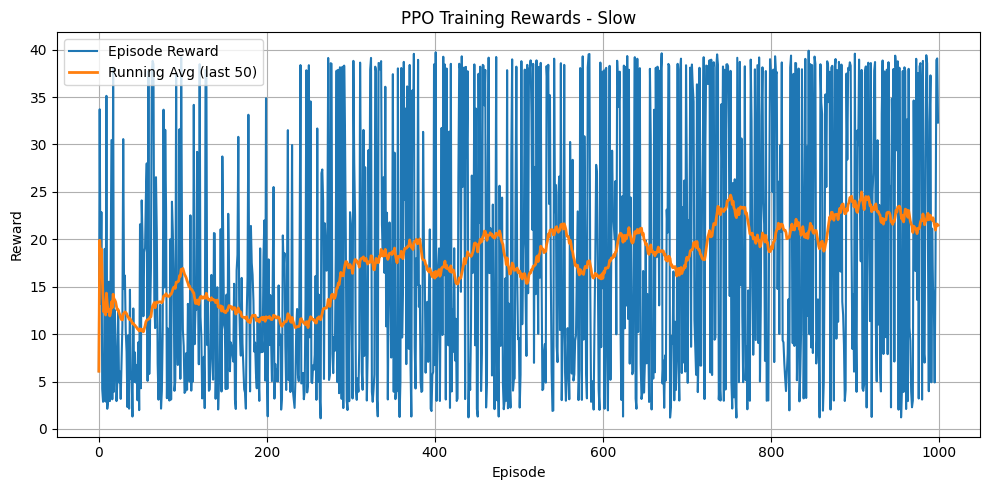


Training agent for scenario: Normal

Training scenario: Normal
Box(-inf, inf, (5, 5), float32)
Episode 10, Reward: 3.95, Running Avg (50): 6.48
Episode 20, Reward: 5.73, Running Avg (50): 9.01
Episode 30, Reward: 5.49, Running Avg (50): 10.38
Episode 40, Reward: 5.27, Running Avg (50): 10.56
Episode 50, Reward: 31.42, Running Avg (50): 10.72
Episode 60, Reward: 1.12, Running Avg (50): 10.52
Episode 70, Reward: 13.48, Running Avg (50): 10.28
Episode 80, Reward: 1.84, Running Avg (50): 9.76
Episode 90, Reward: 30.10, Running Avg (50): 9.14
Episode 100, Reward: 10.63, Running Avg (50): 9.17
Episode 110, Reward: 4.19, Running Avg (50): 10.69
Episode 120, Reward: 19.66, Running Avg (50): 10.45
Episode 130, Reward: 12.33, Running Avg (50): 9.98
Episode 140, Reward: 10.93, Running Avg (50): 10.57
Episode 150, Reward: 15.66, Running Avg (50): 11.02
Episode 160, Reward: 18.12, Running Avg (50): 10.82
Episode 170, Reward: 2.49, Running Avg (50): 11.15
Episode 180, Reward: 15.68, Running Avg (50

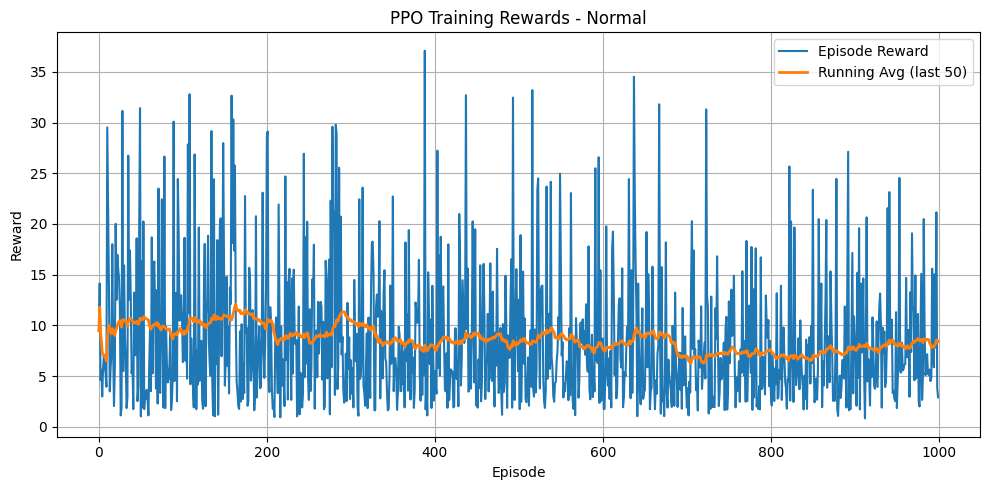


Training agent for scenario: Fast

Training scenario: Fast
Box(-inf, inf, (5, 5), float32)
Episode 10, Reward: 19.82, Running Avg (50): 13.26
Episode 20, Reward: 2.22, Running Avg (50): 9.05
Episode 30, Reward: 2.73, Running Avg (50): 9.55
Episode 40, Reward: 7.67, Running Avg (50): 8.32
Episode 50, Reward: 2.20, Running Avg (50): 8.08
Episode 60, Reward: 9.36, Running Avg (50): 7.06
Episode 70, Reward: 7.40, Running Avg (50): 8.07
Episode 80, Reward: 0.69, Running Avg (50): 7.67
Episode 90, Reward: 11.47, Running Avg (50): 8.43
Episode 100, Reward: 1.53, Running Avg (50): 9.05
Episode 110, Reward: 15.67, Running Avg (50): 9.36
Episode 120, Reward: 15.49, Running Avg (50): 9.64
Episode 130, Reward: 7.40, Running Avg (50): 9.27
Episode 140, Reward: 6.60, Running Avg (50): 8.71
Episode 150, Reward: 2.18, Running Avg (50): 7.77
Episode 160, Reward: 9.58, Running Avg (50): 7.71
Episode 170, Reward: 12.02, Running Avg (50): 7.40
Episode 180, Reward: 2.04, Running Avg (50): 7.60
Episode 190

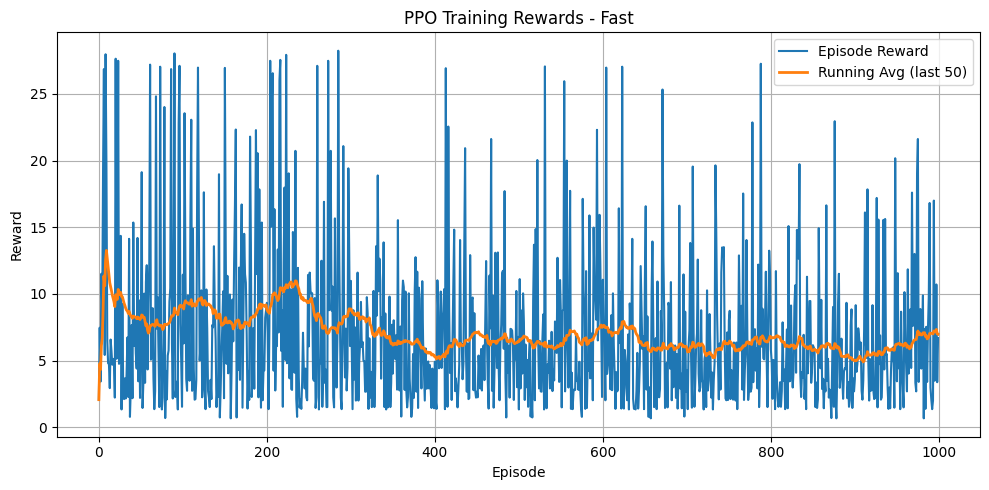

In [13]:

SCENARIOS = {
    "Slow":   {"reward_speed_range": [10, 20]},
    "Normal": {"reward_speed_range": [20, 30]},
    "Fast":   {"reward_speed_range": [30, 40]},
}

def train(cfg, label=""):
    env = gym.make("highway-v0", render_mode="rgb_array").unwrapped
    env.configure(cfg)
    print(f"\nTraining scenario: {label}")
    print(env.observation_space)
    
    state_dim = np.prod(env.observation_space.shape)
    action_dim = env.action_space.n

    # PPO hyperparameters
    max_episodes = 1000
    max_ep_len = 1000
    update_timestep = 4000
    K_epochs = 80
    eps_clip = 0.2
    gamma = 0.99
    lr_actor = 0.0003
    lr_critic = 0.003

    episode_reward_history = []
    running_rewards = []
    last_n_reward = 50

    ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip)

    time_step = 0
    i_episode = 0

    while i_episode < max_episodes:
        obs, _ = env.reset()
        current_ep_reward = 0

        for _ in range(max_ep_len):
            action = ppo_agent.select_action(obs)
            next_obs, reward, done, truncated, info = env.step(action)

            ppo_agent.buffer.rewards.append(reward)
            ppo_agent.buffer.is_terminals.append(done or truncated)

            time_step += 1
            current_ep_reward += reward

            if time_step % update_timestep == 0:
                ppo_agent.update()

            obs = next_obs

            if done or truncated:
                break

        i_episode += 1
        episode_reward_history.append(current_ep_reward)

        running_reward = (
            np.mean(episode_reward_history[-last_n_reward:])
            if len(episode_reward_history) > last_n_reward
            else np.mean(episode_reward_history)
        )
        running_rewards.append(running_reward)
        if i_episode % 10 == 0:
            print(f"Episode {i_episode}, Reward: {current_ep_reward:.2f}, Running Avg ({last_n_reward}): {running_reward:.2f}")

    plt.figure(figsize=(10, 5))
    plt.plot(episode_reward_history, label="Episode Reward")
    plt.plot(running_rewards, label=f"Running Avg (last {last_n_reward})", linewidth=2)
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title(f"PPO Training Rewards - {label}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    env.close()
    return ppo_agent

if __name__ == "__main__":
    trained_agents = {}
    for label, scenario_cfg in SCENARIOS.items():
        cfg = BASE_CONFIG.copy()
        cfg.update(scenario_cfg)
        print(f"\nTraining agent for scenario: {label}")
        agent = train(cfg, label)
        torch.cuda.empty_cache()
        trained_agents[label] = agent

In [ ]:
# CPU time to run 20 episodes for each scenario: 2m54s
# GPU time to run 20 episodes for each scenario: 2m14s

In [14]:
import numpy as np
import pandas as pd

def evaluate_model(env, model, episodes=50, max_steps=1000, is_ppo=True):
    rewards = []
    collisions = []

    for _ in range(episodes):
        state, _ = env.reset()
        total_reward = 0.0
        collision_count = 0
        done = False
        steps = 0

        while not done and steps < max_steps:
            if is_ppo:
                action = model.select_action_eval(state)
            else:
                q_vals = model.predict(state[np.newaxis], verbose=0)[0]
                action = int(np.argmax(q_vals))

            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            total_reward += reward
            if info.get("crashed", False) or reward < 0:
                collision_count += 1

            state = next_state
            steps += 1

        rewards.append(total_reward)
        collisions.append(collision_count)

    avg_collisions = np.mean(collisions)
    return rewards, avg_collisions

def evaluate_all_agents(trained_agents, driver_configs, base_config, episodes=50, is_ppo=True):
    results = []

    for label, agent in trained_agents.items():
        print(f"\nEvaluating agent: {label}")

        cfg = base_config.copy()
        cfg.update(driver_configs[label])
        env = gym.make("highway-v0", render_mode=None).unwrapped
        env.configure(cfg)

        rewards, avg_collisions = evaluate_model(env, agent, episodes=episodes, is_ppo=is_ppo)

        results.append({
            "behavior": label,
            "mean_reward": np.mean(rewards),
            "std_reward": np.std(rewards),
            "avg_collisions": avg_collisions
        })

        env.close()

    df = pd.DataFrame(results)
    print("\nEvaluation Results:")
    print(df.to_string(index=False))
    return df


In [16]:
df = evaluate_all_agents(trained_agents, SCENARIOS, BASE_CONFIG, episodes=50, is_ppo=True)


Evaluating agent: Slow

Evaluating agent: Normal

Evaluating agent: Fast

Evaluation Results:
behavior  mean_reward  std_reward  avg_collisions
    Slow    38.702222    0.910146            0.00
  Normal    17.336136    9.145981            0.94
    Fast    10.894222    7.359418            0.94
